# NB2: Phylogeny: ML analysis with RAxML

The data sets used in this notebook were generated with ipyrad (see [notebook here]()). You can re-create the data sets used here by running that notebook. 

### Table of contents
[Software installation (conda)](#Required-software)  
[Phylogenetic analysis (raxml)](#Analysis-RAxML)  
[Tree plots (toytree)](#Tree plot)



## Required software
All software required for this notebook can be installed locally using *conda*. 

In [6]:
## conda install toytree   -c eaton-lab
## conda install ipyrad    -c ipyrad 
## conda install raxml     -c bioconda

In [7]:
## import packages
import ipyrad as ip
import ipyrad.analysis as ipa
import toyplot
import toytree
import numpy as np
import glob

## print ipyrad info
print "ipyrad v.{}".format(ip.__version__)

ipyrad v.0.6.20


## Cluster setup
We will distribute jobs across an HPC cluster using the ipyparallel library (which is installed as a dependency of ipyrad). Start an ipcluster instance and check your connection below.  

In [48]:
## print ipyparallel cluster information
import ipyparallel as ipp
ipyclient = ipp.Client()
print ip.cluster_info(ipyclient)

host compute node: [40 cores] on tinus


### A function to select samples from clades
This is a convenient function to return only the sample names that belong to a given clade, either "pharma", "urost", "urost1" or "urost2", corresponding to major clades in our data set. 

In [8]:
def get_subsample_names(data, clade):
    
    ## known clades
    c1 = ["tonduzii", "maxima", "yoponens", "glabrata", "insipida"]
    c2 = ["nymph", "obtus", "pope", "bull", "citri", "paraen",
          "pertus", "perfor", "dugan", "turbin", "colub", 
          "costa", "tria", "trig"]
    
    ## select clades from a dict
    clades={
        "pharmacosycea": c1,
        "americana": c2,
    }
    
    ## return selected clade names
    keys = data.samples.keys()
    names = [i for i in keys if any([bit in i for bit in clades[clade]])]
    return names

### Create subsample data sets
In the assembly notebook we created several data sets which include *all* (76) samples that passed our initial filtering, meaning they had at least N consensus reads. Here we create several additional subsets of the data for phylogenetic inference. In particular, we will remove known hybrid samples from the data, where hybrids were identified from STRUCTURE and ABBA-BABA analyses (see other notebooks). 

In [9]:
## list of hybrid samples
pharma_hybrids = [
    "B131_glabrataXmaxima", 
    "A96_glabrata", 
    "B123_maxima", 
    "C18_maxima", 
]

america_hybrids = [
    "C31_triangle",
    "C30_triangle",
    "A55_triangle",
    "C11_costaricana",
    "A87_costaricana",
    "C04_colubrinae",
]

In [11]:
## parent from which branches will be made
parent = ip.load_json("analysis-ipyrad/ficus_dhi_s4.json")

## new pharma subsample no-hybrids branches
subs = list(set(get_subsample_names(parent, "pharmacosycea")) - set(pharma_hybrids))
pharma = parent.branch("pharma_dhi_s10_nohybrids", subsamples=subs)
pharma.set_params("min_samples_locus", 10)
pharma.run("7", force=True)

## new america subsample no-hybrids branches
subs = list(set(get_subsample_names(parent, "americana")) - set(america_hybrids))
america = parent.branch("america_dhi_s20_nohybrids", subsamples=subs)
america.set_params("min_samples_locus", 20)
america.run("7", force=True)

  loading Assembly: ficus_dhi_s4
  from saved path: ~/Documents/Ficus/analysis-ipyrad/ficus_dhi_s4.json

  Assembly: pharma_dhi_s10_nohybrids
  [####################] 100%  filtering loci        | 0:00:14 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:38 | s7 | 
  [####################] 100%  building alleles      | 0:00:43 | s7 | 
  [####################] 100%  building vcf file     | 0:00:52 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:00 | s7 | 
  [####################] 100%  building arrays       | 0:00:12 | s7 | 
  [####################] 100%  writing outfiles      | 0:00:09 | s7 | 
  Outfiles written to: ~/Documents/Ficus/analysis-ipyrad/pharma_dhi_s10_nohybrids_outfiles

  Assembly: america_dhi_s20_nohybrids
  [####################] 100%  filtering loci        | 0:00:33 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:37 | s7 | 
  [####################] 100%  building alleles      | 0:00:44 | s7 | 
  [###############

# Analysis `RAxML`
(Maximum Likelihood & rapid bootstrapping)

#### Create additional data sets with obvious hybrids excluded

In [48]:
## data sets for which we want to infer an ML tree
keys = [
    "ficus_dhi_s20",             # high depth dsets
    "ficus_dhi_s10",             #
    "ficus_dhi_s4",              #
    "pharma_dhi_s10_nohybrids",  # no hybrid samples
    "america_dhi_s20_nohybrids", # 
    "ficus_dlo_s4",              # most possible data
]

## a dictionary of raxml objects
raxdict = {}

## iterate over keys (data sets)
for key in keys:
    data = dsets[key]
    
    ## set outgroup
    if "ficus" in key:
        out = get_sample_names(data, "pharma")
    else:
        out = None
    
    ## init a raxml object
    raxdict[key] = ipa.raxml(
        name=data.name, 
        data=data.outfiles.phy, 
        o=out,
        N=100, 
        T=10)
    
## print the last rax command for prosperities sake
raxdict[key].command

'raxmlHPC-PTHREADS-AVX -f a -T 10 -m GTRGAMMA -N 100 -x 12345 -p 54321 -n ficus_dlo_s4 -w /home/deren/Documents/Ficus/analysis-raxml -s /home/deren/Documents/Ficus/analysis-ipyrad/ficus_dlo_s4_outfiles/ficus_dlo_s4.phy -o C17_maxima,C18_maxima,B123_maxima,B130_glabrataXmaxima,B133_glabrata,C47_yoponensis,C48_tonduzii,B119_maxima,B128_insipida,B126_insipida,C46_yoponensis,B127_insipida,C15_insipida,C45_yoponensis,C50_insipida,A95_insipida,B131_glabrataXmaxima,B134_glabrata,A94_maxima,B118_maxima,B120_maxima,A96_glabrata,A97_glabrata'

#### Run the raxml analysis for each object

In [ ]:
## call raxml on each data set (command above)
for rax in raxdict:
    raxdict[rax].run()

## Plot trees

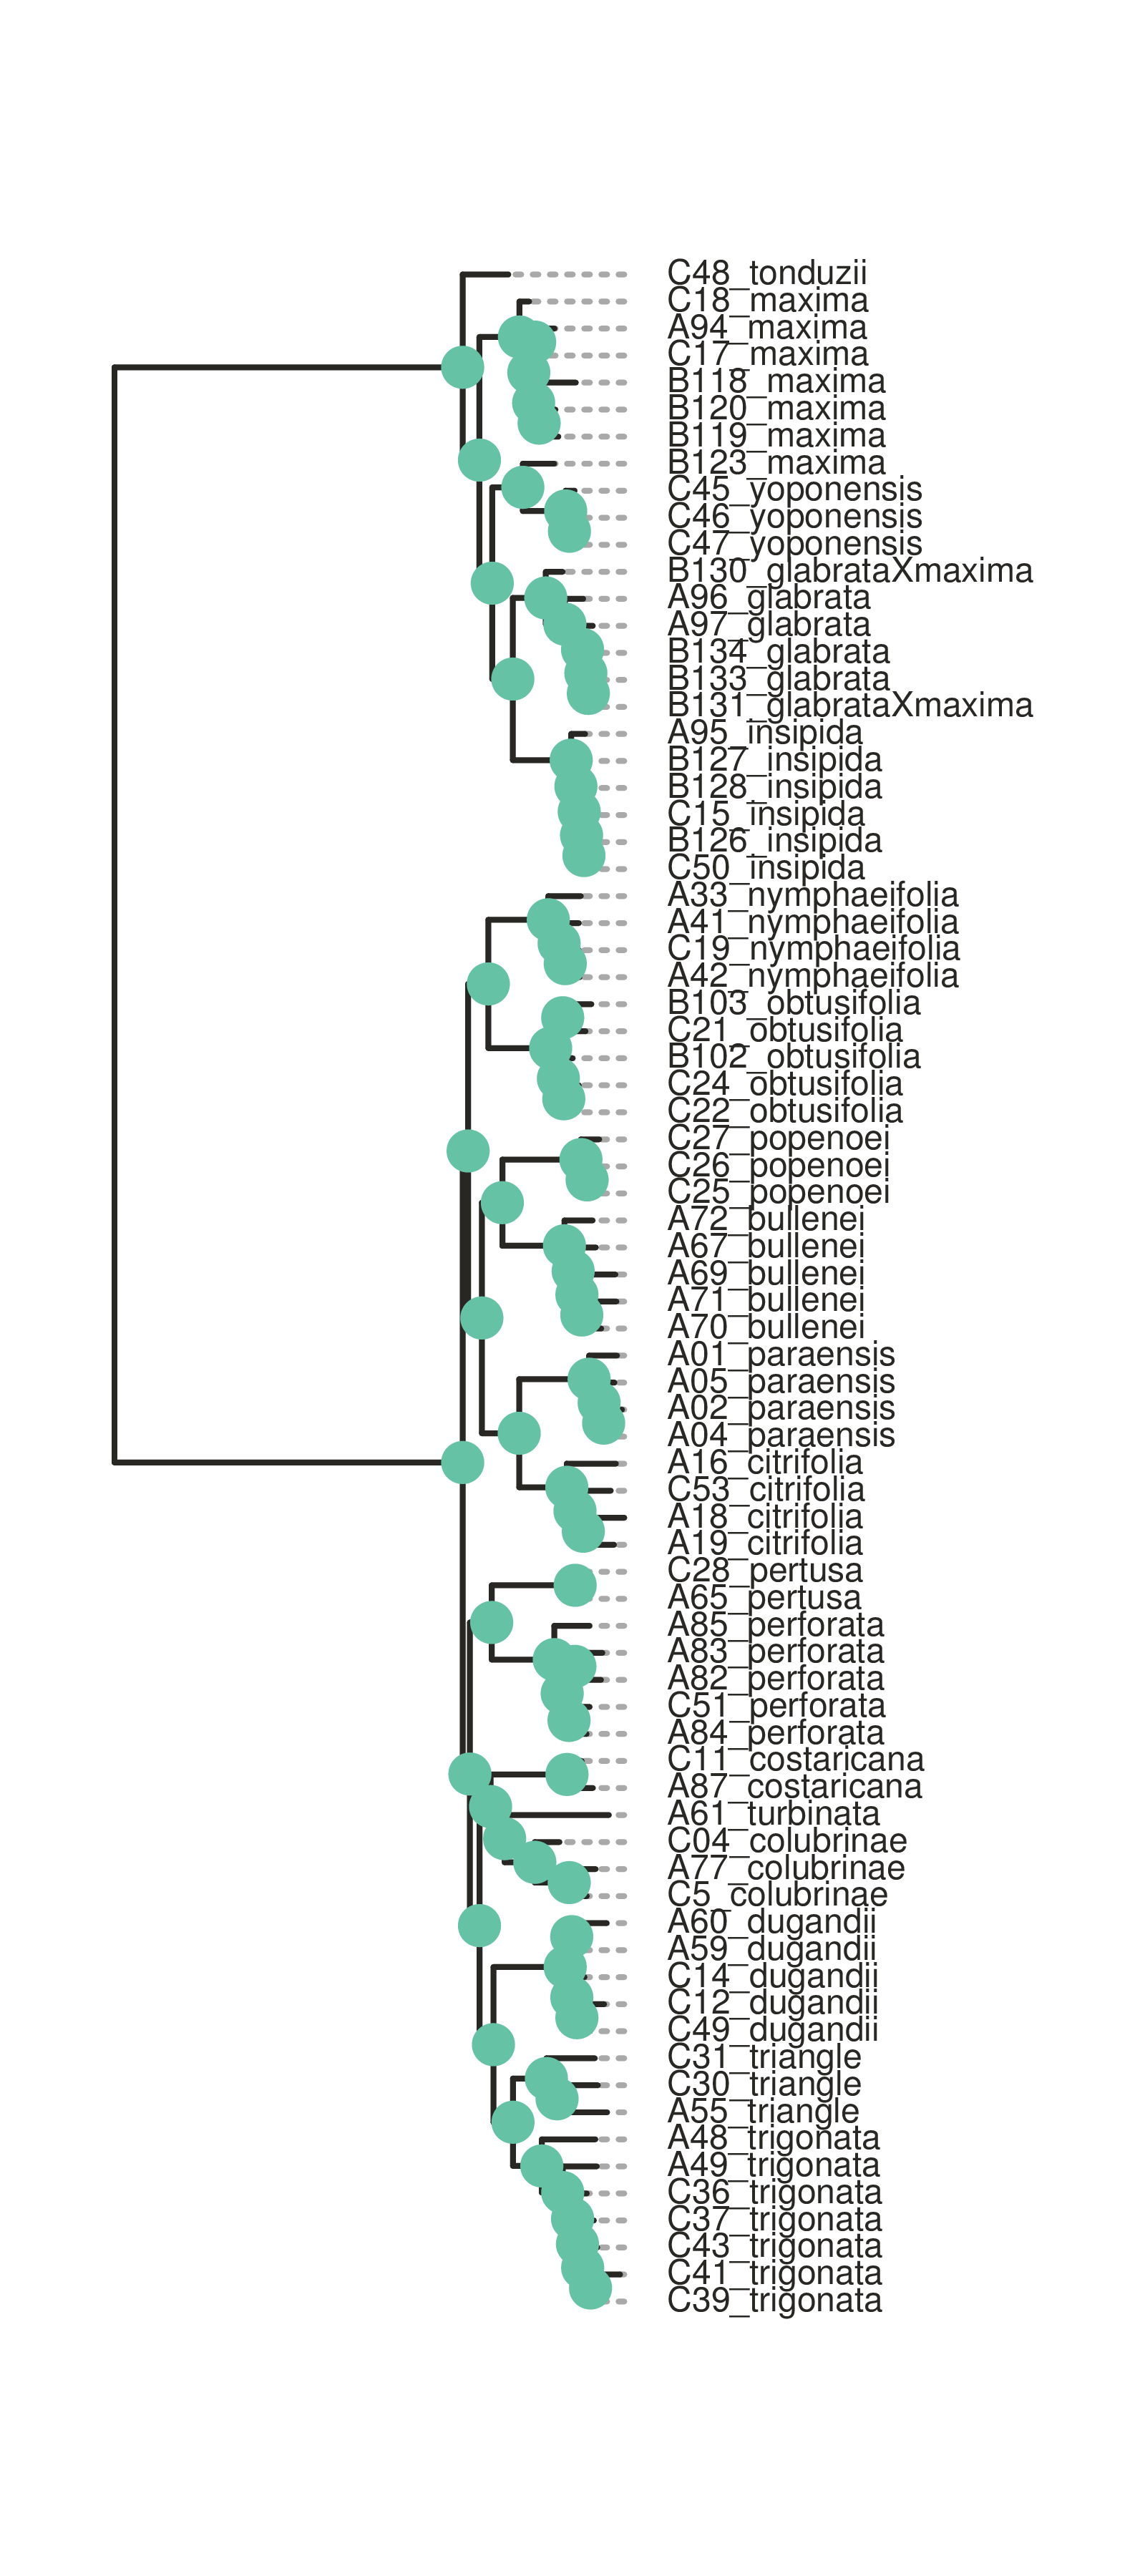

In [15]:
## draw the pruned "urostigma" tree
tre = toytree.tree("analysis-raxml/RAxML_bipartitions.ficus_dhi_s10")
#tre.tree.prune(get_subsample_names(parent, 'americana'))

c, a = tre.draw(
    width=400, 
    height=900,
    node_labels=tre.get_node_values("support"),
    use_edge_lengths=True,
    tip_labels_align=True,
    );

toyplot.html.render(c, "figures/ficus_dhi_s10.html")
c

In [23]:
## draw the pruned "urostigma" tree
tre = toytree.tree("analysis-raxml/RAxML_bipartitions.ficus_dhi_s10")
tre.tree.prune(get_sample_names(parent, 'urost'))

## colormap support values
palette = toyplot.color.brewer.map(
    name="Greys", domain_min=50, domain_max=100, reverse=True)
vals = np.array(tre.get_node_values("support", 1, 1))
colors = toyplot.color.broadcast((vals, palette), shape=vals.shape)
colors = colors.tolist()

## draw tree
tre.draw(
    width=400, 
    height=700,
    node_labels=True, #tre.get_node_values("support"),
    node_color=colors,
    node_style={"stroke": "#262626"},
    node_size=[12 if i else 0 for i in tre.get_node_values("support", 1, 0)],
    use_edge_lengths=True,
    tip_labels_align=True,
    );

A33_nymphaeifolia A41_nymphaeifolia C19_nymphaeifolia A42_nymphaeifolia B103_obtusifolia C21_obtusifolia B102_obtusifolia C24_obtusifolia C22_obtusifolia A01_paraensis A05_paraensis A02_paraensis A04_paraensis A16_citrifolia C53_citrifolia A18_citrifolia A19_citrifolia A72_bullenei A67_bullenei A69_bullenei A71_bullenei A70_bullenei C28_pertusa A65_pertusa A85_perforata A83_perforata A82_perforata C51_perforata A84_perforata C11_costaricana A87_costaricana A61_turbinata C04_colubrinae A77_colubrinae C5_colubrinae A60_dugandii A59_dugandii C14_dugandii C12_dugandii C49_dugandii C31_triangle C30_triangle A55_triangle A48_trigonata A49_trigonata C36_trigonata C37_trigonata C43_trigonata C41_trigonata C39_trigonata idx: 0
name: 0
dist: 0.0
support: 100 idx: 1
name: 24
dist: 0.000370331449965
support: 87 idx: 2
name: 25
dist: 0.00138607305694
support: 100 idx: 3
name: 26
dist: 0.00410409843672
support: 100 idx: 4
name: 27
dist: 0.000741278339359
support: 97 idx: 5
name: 28
dist: 0.00042132940231
support: 94 idx: 6
name: 29
dist: 0.00426702021954
support: 100 idx: 7
name: 30
dist: 0.000825859005251
support: 65 idx: 8
name: 31
dist: 0.000528601106224
support: 68 idx: 9
name: 32
dist: 0.000371377317321
support: 88 idx: 10
name: 33
dist: 0.000941933029497
support: 100 idx: 11
name: 41
dist: 0.0025562568953
support: 100 idx: 12
name: 42
dist: 0.00478688052575
support: 100 idx: 13
name: 43
dist: 0.000687932834194
support: 99 idx: 14
name: 44
dist: 0.000308400596166
support: 100 idx: 15
name: 45
dist: 0.00326139945388
support: 96 idx: 16
name: 46
dist: 0.000560394253508
support: 48 idx: 17
name: 47
dist: 0.000569550845303
support: 88 idx: 18
name: 37
dist: 0.0042511103636
support: 100 idx: 19
name: 38
dist: 0.000597655899812
support: 67 idx: 20
name: 39
dist: 0.000255547396373
support: 40 idx: 21
name: 40
dist: 0.000335769730991
support: 76 idx: 22
name: 48
dist: 0.000494908121571
support: 98 idx: 23
name: 49
dist: 0.00149098491821
support: 100 idx: 24
name: 50
dist: 0.00571567040674
support: 100 idx: 25
name: 51
dist: 0.00428898271103
support: 100 idx: 26
name: 52
dist: 0.000539385328615
support: 76 idx: 27
name: 53
dist: 0.000866501036964
support: 100 idx: 28
name: 54
dist: 0.000465996806217
support: 58 idx: 29
name: 55
dist: 0.000654605212062
support: 45 idx: 30
name: 56
dist: 0.000758740277245
support: 66 idx: 31
name: 57
dist: 0.0052324910133
support: 100 idx: 32
name: 58
dist: 0.000962349168115
support: 100 idx: 33
name: 59
dist: 0.00206808378058
support: 100 idx: 34
name: 60
dist: 0.00235533026764
support: 100 idx: 35
name: 61
dist: 0.00095607411787
support: 89 idx: 36
name: 62
dist: 0.00491508190665
support: 100 idx: 37
name: 63
dist: 0.00044515399286
support: 64 idx: 38
name: 64
dist: 0.00045067059714
support: 56 idx: 39
name: 65
dist: 0.000347951898265
support: 66 idx: 40
name: 66
dist: 0.00133956196394
support: 100 idx: 41
name: 67
dist: 0.00228697818893
support: 100 idx: 42
name: 68
dist: 0.000730301381252
support: 98 idx: 43
name: 69
dist: 0.00197221537165
support: 100 idx: 44
name: 70
dist: 0.00143071027298
support: 100 idx: 45
name: 71
dist: 0.000675952326604
support: 98 idx: 46
name: 72
dist: 0.000334814006962
support: 35 idx: 47
name: 73
dist: 0.000354629365762
support: 60 idx: 48
name: 74
dist: 0.000540288189594
support: 98 idx: 49
name: A33_nymphaeifolia
dist: 0.00222904749361
support: 100 idx: 50
name: A41_nymphaeifolia
dist: 0.00135244467545
support: 100 idx: 51
name: C19_nymphaeifolia
dist: 0.000936812579557
support: 100 idx: 52
name: A42_nymphaeifolia
dist: 0.000983247741333
support: 100 idx: 53
name: B103_obtusifolia
dist: 0.00196529412456
support: 100 idx: 54
name: C21_obtusifolia
dist: 0.00155268282717
support: 100 idx: 55
name: B102_obtusifolia
dist: 0.000978173201129
support: 100 idx: 56
name: C24_obtusifolia
dist: 0.00103056675162
support: 100 idx: 57
name: C22_obtusifolia
dist: 0.000849034152063
support: 100 idx: 58
name: A01_paraensis
dist: 0.00191381215422
support: 100 idx: 59
name: A05_paraensis
dist: 0.00